# Tarea 5

In [1]:
# Configuración para GPU

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import optuna
import mlflow
import dagshub

np.random.seed(42)
tf.random.set_seed(42)

2025-11-26 23:48:48.534469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/enriq/tf-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Verificar y configurar GPU

gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configurada: {gpus[0].name}")
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")

GPUs disponibles: 1
GPU configurada: /physical_device:GPU:0


In [4]:
# Dagshub
dagshub.init(repo_owner='404brainnotfound-ai', repo_name='Tarea_5', mlflow=True)
print(f"URI de seguimiento: {mlflow.get_tracking_uri()}")

Accessing as 404brainnotfound-ai

Initialized MLflow to track repo "404brainnotfound-ai/Tarea_5"

Repository 404brainnotfound-ai/Tarea_5 initialized!

URI de seguimiento: https://dagshub.com/404brainnotfound-ai/Tarea_5.mlflow


In [5]:
# Dataset
df = pd.read_csv('global_house_purchase_dataset.csv')
df = df.drop('property_id', axis=1)

print(f"Forma: {df.shape}")
print(f"Clases: {df['decision'].value_counts().to_dict()}")

Forma: (200000, 24)
Clases: {0: 153932, 1: 46068}


In [6]:
# Codificación one hot para variables
columnas_categoricas = ['country', 'city', 'property_type', 'furnishing_status']
df_codificado = pd.get_dummies(df, columns=columnas_categoricas, dtype=int)

print(f"Características después de codificar: {df_codificado.shape[1] - 1}")

Características después de codificar: 81


In [7]:
# Separar X, y
X = df_codificado.drop('decision', axis=1).values
y = df_codificado['decision'].values

# Normalizar
escalador = MinMaxScaler()
X_escalado = escalador.fit_transform(X)

print(f"Forma de X: {X_escalado.shape}")
print(f"Forma de y: {y.shape}")

Forma de X: (200000, 81)
Forma de y: (200000,)


In [9]:
# División 70/20/10
X_entreno, X_temp, y_entreno, y_temp = train_test_split(X_escalado, y, test_size=0.30, random_state=42, stratify=y)
X_prueba, X_validacion, y_prueba, y_validacion = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

print(f"Entreno: {len(X_entreno)} ({len(X_entreno)/len(X)*100:.1f}%)")
print(f"Prueba:  {len(X_prueba)} ({len(X_prueba)/len(X)*100:.1f}%)")
print(f"Validación: {len(X_validacion)} ({len(X_validacion)/len(X)*100:.1f}%)")

num_caracteristicas = X_entreno.shape[1]
print(f"\nNúmero de características: {num_caracteristicas}")

Entreno: 140000 (70.0%)
Prueba:  40000 (20.0%)
Validación: 20000 (10.0%)

Número de características: 81


In [10]:
def crear_modelo(trial):
    
    # Hiperparámetros
    n_capas = trial.suggest_int("n_capas", 2, 4)
    unidades_1 = trial.suggest_int("unidades_1", 128, 512, step=128)
    unidades_2 = trial.suggest_int("unidades_2", 64, 256, step=64)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    valor_l2 = trial.suggest_float("valor_l2", 1e-6, 1e-3, log=True)
    tasa_aprendizaje = trial.suggest_float("tasa_aprendizaje", 1e-5, 1e-3, log=True)
    
    # Modelo Dense
    modelo = keras.Sequential()
    
    # Primera capa
    modelo.add(layers.Dense(unidades_1, activation='relu', 
                           kernel_regularizer=regularizers.l2(valor_l2),
                           input_shape=(num_caracteristicas,)))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.Dropout(dropout))
    
    # Capas intermedias
    for i in range(n_capas - 1):
        modelo.add(layers.Dense(unidades_2, activation='relu',
                               kernel_regularizer=regularizers.l2(valor_l2)))
        modelo.add(layers.BatchNormalization())
        modelo.add(layers.Dropout(dropout))
    
    # Capa de salida
    modelo.add(layers.Dense(1, activation='sigmoid'))
    
    optimizador = keras.optimizers.Adam(learning_rate=tasa_aprendizaje)
    modelo.compile(optimizer=optimizador, loss='binary_crossentropy', metrics=['accuracy'])
    
    return modelo

In [11]:
def objetivo(trial):
    modelo = crear_modelo(trial)
    
    tamano_lote = 128
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0)]
    
    # Entrenar solo con entreno
    historial = modelo.fit(
        X_entreno, y_entreno,
        batch_size=tamano_lote,
        epochs=15,
        callbacks=callbacks,
        verbose=0)
    
    # Evaluar en prueba
    perdida, precision = modelo.evaluate(X_prueba, y_prueba, verbose=0)
    
    # Liberar memoria
    del modelo
    keras.backend.clear_session()
    
    return perdida

In [12]:
# Optimización con Optuna
mlflow.set_experiment("Tarea5_Optuna")

estudio = optuna.create_study(direction="minimize", study_name="prediccion_casa")
estudio.optimize(objetivo, n_trials=30, show_progress_bar=True)

print(f"\nMejor intento: {estudio.best_trial.number}")
print(f"Mejor pérdida: {estudio.best_value:.6f}")
print(f"\nMejores parámetros:")
for clave, valor in estudio.best_params.items():
    print(f"  {clave}: {valor}")

[I 2025-11-26 23:58:05,777] A new study created in memory with name: prediccion_casa
  0%|          | 0/30 [00:00<?, ?it/s]/home/enriq/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764223086.240848    3260 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1764223086.491939    3260 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2857 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2025-11-26 23:58:15.009252: I external/local_xla/xla/service/service.cc:163] XLA service 0x706a7c007610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

[I 2025-11-27 00:01:25,394] Trial 0 finished with value: 0.022582845762372017 and parameters: {'n_capas': 4, 'unidades_1': 128, 'unidades_2': 256, 'dropout': 0.46567924867624183, 'valor_l2': 8.405452643476421e-05, 'tasa_aprendizaje': 0.0007820929266378541}. Best is trial 0 with value: 0.022582845762372017.


Best trial: 1. Best value: 0.00735917:   7%|▋         | 2/30 [05:59<1:22:16, 176.29s/it]

[I 2025-11-27 00:04:05,364] Trial 1 finished with value: 0.007359170354902744 and parameters: {'n_capas': 2, 'unidades_1': 256, 'unidades_2': 64, 'dropout': 0.37949437413517373, 'valor_l2': 5.991447875098912e-06, 'tasa_aprendizaje': 0.0004039905621101411}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  10%|█         | 3/30 [08:31<1:14:19, 165.15s/it]

[I 2025-11-27 00:06:37,263] Trial 2 finished with value: 0.20905248820781708 and parameters: {'n_capas': 3, 'unidades_1': 128, 'unidades_2': 64, 'dropout': 0.3755672643500845, 'valor_l2': 1.5773624030825565e-05, 'tasa_aprendizaje': 1.1682198879927657e-05}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  13%|█▎        | 4/30 [11:19<1:11:59, 166.13s/it]

[I 2025-11-27 00:09:24,889] Trial 3 finished with value: 0.014039883390069008 and parameters: {'n_capas': 2, 'unidades_1': 512, 'unidades_2': 256, 'dropout': 0.20982606726739844, 'valor_l2': 0.00032247394293704104, 'tasa_aprendizaje': 0.00038059830406529156}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  17%|█▋        | 5/30 [14:32<1:13:17, 175.90s/it]

[I 2025-11-27 00:12:38,109] Trial 4 finished with value: 0.1568838655948639 and parameters: {'n_capas': 4, 'unidades_1': 384, 'unidades_2': 256, 'dropout': 0.3526902785882766, 'valor_l2': 0.00019481503681585696, 'tasa_aprendizaje': 5.750708022268836e-05}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  20%|██        | 6/30 [49:57<5:35:27, 838.65s/it]

[I 2025-11-27 00:48:03,278] Trial 5 finished with value: 0.011875941418111324 and parameters: {'n_capas': 3, 'unidades_1': 256, 'unidades_2': 256, 'dropout': 0.2706117572917017, 'valor_l2': 8.597236061188818e-06, 'tasa_aprendizaje': 0.0008885280367897803}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  23%|██▎       | 7/30 [51:49<3:50:26, 601.16s/it]

[I 2025-11-27 00:49:55,485] Trial 6 finished with value: 0.45661890506744385 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 256, 'dropout': 0.38780308311109635, 'valor_l2': 0.0009153650750738264, 'tasa_aprendizaje': 1.2170729678684407e-05}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  27%|██▋       | 8/30 [53:35<2:42:37, 443.50s/it]

[I 2025-11-27 00:51:41,415] Trial 7 finished with value: 0.011771067976951599 and parameters: {'n_capas': 4, 'unidades_1': 256, 'unidades_2': 128, 'dropout': 0.37935455107495997, 'valor_l2': 6.73096064282985e-06, 'tasa_aprendizaje': 0.00020615935953555574}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  30%|███       | 9/30 [55:23<1:58:26, 338.43s/it]

[I 2025-11-27 00:53:28,804] Trial 8 finished with value: 0.022145655006170273 and parameters: {'n_capas': 2, 'unidades_1': 256, 'unidades_2': 128, 'dropout': 0.4532535716776607, 'valor_l2': 5.2784689594393735e-05, 'tasa_aprendizaje': 0.00014709674189449139}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  33%|███▎      | 10/30 [57:28<1:30:55, 272.77s/it]

[I 2025-11-27 00:55:34,563] Trial 9 finished with value: 0.01723330281674862 and parameters: {'n_capas': 2, 'unidades_1': 512, 'unidades_2': 256, 'dropout': 0.37283253902869434, 'valor_l2': 0.0004987589108437296, 'tasa_aprendizaje': 0.0004349248201463673}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  37%|███▋      | 11/30 [59:13<1:10:07, 221.44s/it]

[I 2025-11-27 00:57:19,622] Trial 10 finished with value: 0.11475389450788498 and parameters: {'n_capas': 3, 'unidades_1': 128, 'unidades_2': 64, 'dropout': 0.2821159707690904, 'valor_l2': 1.1489448282415182e-06, 'tasa_aprendizaje': 5.098299537161949e-05}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  40%|████      | 12/30 [1:01:14<57:13, 190.77s/it]  

[I 2025-11-27 00:59:20,237] Trial 11 finished with value: 0.010426797904074192 and parameters: {'n_capas': 4, 'unidades_1': 256, 'unidades_2': 128, 'dropout': 0.42496863772859816, 'valor_l2': 3.6794936587928374e-06, 'tasa_aprendizaje': 0.00019051924764168772}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 1. Best value: 0.00735917:  43%|████▎     | 13/30 [1:03:12<47:46, 168.61s/it]

[I 2025-11-27 01:01:17,870] Trial 12 finished with value: 0.009006055071949959 and parameters: {'n_capas': 3, 'unidades_1': 256, 'unidades_2': 128, 'dropout': 0.4992219772044605, 'valor_l2': 2.14396966333637e-06, 'tasa_aprendizaje': 0.000240943987585185}. Best is trial 1 with value: 0.007359170354902744.


Best trial: 13. Best value: 0.00654011:  47%|████▋     | 14/30 [1:05:19<41:41, 156.32s/it]

[I 2025-11-27 01:03:25,768] Trial 13 finished with value: 0.0065401094034314156 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.48193138506574673, 'valor_l2': 1.1721494032702744e-06, 'tasa_aprendizaje': 0.00037509832294593576}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  50%|█████     | 15/30 [1:07:11<35:43, 142.89s/it]

[I 2025-11-27 01:05:17,550] Trial 14 finished with value: 0.03878061845898628 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.31529764515608416, 'valor_l2': 1.108927722157891e-06, 'tasa_aprendizaje': 7.82012764631472e-05}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  53%|█████▎    | 16/30 [1:09:20<32:20, 138.64s/it]

[I 2025-11-27 01:07:26,317] Trial 15 finished with value: 0.012830793857574463 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 192, 'dropout': 0.4314152903390188, 'valor_l2': 2.0102325451918875e-05, 'tasa_aprendizaje': 0.00045218797757603715}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  57%|█████▋    | 17/30 [1:11:23<28:59, 133.82s/it]

[I 2025-11-27 01:09:28,941] Trial 16 finished with value: 0.15037809312343597 and parameters: {'n_capas': 3, 'unidades_1': 512, 'unidades_2': 64, 'dropout': 0.4870361586092213, 'valor_l2': 3.6450673410956453e-06, 'tasa_aprendizaje': 3.0815009358514955e-05}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  60%|██████    | 18/30 [1:13:05<24:50, 124.23s/it]

[I 2025-11-27 01:11:10,823] Trial 17 finished with value: 0.0074141076765954494 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 192, 'dropout': 0.41906824012508637, 'valor_l2': 2.5125413011983373e-06, 'tasa_aprendizaje': 0.0005868747251276321}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  63%|██████▎   | 19/30 [1:14:53<21:55, 119.63s/it]

[I 2025-11-27 01:12:59,733] Trial 18 finished with value: 0.018681224435567856 and parameters: {'n_capas': 2, 'unidades_1': 256, 'unidades_2': 64, 'dropout': 0.3260174980226912, 'valor_l2': 8.72468903259259e-06, 'tasa_aprendizaje': 0.00011696242385064577}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  67%|██████▋   | 20/30 [1:17:09<20:44, 124.48s/it]

[I 2025-11-27 01:15:15,527] Trial 19 finished with value: 0.008388625457882881 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.212648057103239, 'valor_l2': 1.0006727929411624e-06, 'tasa_aprendizaje': 0.00035489498163352107}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  70%|███████   | 21/30 [1:19:15<18:43, 124.81s/it]

[I 2025-11-27 01:17:21,121] Trial 20 finished with value: 0.008707699365913868 and parameters: {'n_capas': 3, 'unidades_1': 128, 'unidades_2': 192, 'dropout': 0.4086729097919626, 'valor_l2': 4.933484586660917e-06, 'tasa_aprendizaje': 0.00025723661157732686}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  73%|███████▎  | 22/30 [1:21:20<16:40, 125.02s/it]

[I 2025-11-27 01:19:26,626] Trial 21 finished with value: 0.007556880358606577 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 192, 'dropout': 0.46408883221156966, 'valor_l2': 2.1954932272511653e-06, 'tasa_aprendizaje': 0.000607187254891657}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  77%|███████▋  | 23/30 [1:23:20<14:24, 123.44s/it]

[I 2025-11-27 01:21:26,372] Trial 22 finished with value: 0.008334715850651264 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 192, 'dropout': 0.4229294416585363, 'valor_l2': 2.148110672522961e-06, 'tasa_aprendizaje': 0.0009965124564594112}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  80%|████████  | 24/30 [1:25:22<12:18, 123.13s/it]

[I 2025-11-27 01:23:28,783] Trial 23 finished with value: 0.011197075247764587 and parameters: {'n_capas': 2, 'unidades_1': 512, 'unidades_2': 128, 'dropout': 0.44695743742494326, 'valor_l2': 1.35569725028622e-05, 'tasa_aprendizaje': 0.0005294102573348646}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  83%|████████▎ | 25/30 [1:27:27<10:18, 123.62s/it]

[I 2025-11-27 01:25:33,553] Trial 24 finished with value: 0.0067955506965518 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 192, 'dropout': 0.40192089186324204, 'valor_l2': 2.3642624468602677e-06, 'tasa_aprendizaje': 0.00028841830075890457}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  87%|████████▋ | 26/30 [1:29:37<08:21, 125.41s/it]

[I 2025-11-27 01:27:43,146] Trial 25 finished with value: 0.01335595827549696 and parameters: {'n_capas': 2, 'unidades_1': 256, 'unidades_2': 128, 'dropout': 0.3445394673146297, 'valor_l2': 2.7522320681373984e-05, 'tasa_aprendizaje': 0.0003169757234185196}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  90%|█████████ | 27/30 [1:32:11<06:42, 134.02s/it]

[I 2025-11-27 01:30:17,251] Trial 26 finished with value: 0.007048497907817364 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.39745661292449036, 'valor_l2': 1.5592650369446252e-06, 'tasa_aprendizaje': 0.00017539191468063842}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  93%|█████████▎| 28/30 [1:35:04<04:51, 145.59s/it]

[I 2025-11-27 01:33:09,823] Trial 27 finished with value: 0.010596007108688354 and parameters: {'n_capas': 3, 'unidades_1': 512, 'unidades_2': 128, 'dropout': 0.47825675151390334, 'valor_l2': 1.6325719587945135e-06, 'tasa_aprendizaje': 0.00011974965871693592}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011:  97%|█████████▋| 29/30 [1:37:24<02:24, 144.00s/it]

[I 2025-11-27 01:35:30,131] Trial 28 finished with value: 0.009974529035389423 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 192, 'dropout': 0.39985547140091854, 'valor_l2': 3.409723705361805e-06, 'tasa_aprendizaje': 0.00014723438989321553}. Best is trial 13 with value: 0.0065401094034314156.


Best trial: 13. Best value: 0.00654011: 100%|██████████| 30/30 [1:39:33<00:00, 199.12s/it]

[I 2025-11-27 01:37:39,304] Trial 29 finished with value: 0.07912696897983551 and parameters: {'n_capas': 4, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.44431475078038163, 'valor_l2': 1.3977784489449164e-06, 'tasa_aprendizaje': 8.375952042574526e-05}. Best is trial 13 with value: 0.0065401094034314156.

Mejor intento: 13
Mejor pérdida: 0.006540

Mejores parámetros:
  n_capas: 3
  unidades_1: 384
  unidades_2: 64
  dropout: 0.48193138506574673
  valor_l2: 1.1721494032702744e-06
  tasa_aprendizaje: 0.00037509832294593576


In [13]:
# Búsqueda refinada alrededor del mejor modelo

def objetivo_refinado(trial):
    n_capas = trial.suggest_int("n_capas", 2, 3)
    unidades_1 = trial.suggest_int("unidades_1", 320, 448, step=64)
    unidades_2 = trial.suggest_int("unidades_2", 64, 128, step=64)
    dropout = trial.suggest_float("dropout", 0.40, 0.50)
    valor_l2 = trial.suggest_float("valor_l2", 1e-7, 1e-5, log=True)
    tasa_aprendizaje = trial.suggest_float("tasa_aprendizaje", 2e-4, 6e-4, log=True)
    
    modelo = keras.Sequential()
    modelo.add(layers.Dense(unidades_1, activation='relu', 
                           kernel_regularizer=regularizers.l2(valor_l2),
                           input_shape=(num_caracteristicas,)))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.Dropout(dropout))
    
    for i in range(n_capas - 1):
        modelo.add(layers.Dense(unidades_2, activation='relu',
                               kernel_regularizer=regularizers.l2(valor_l2)))
        modelo.add(layers.BatchNormalization())
        modelo.add(layers.Dropout(dropout))
    
    modelo.add(layers.Dense(1, activation='sigmoid'))
    
    optimizador = keras.optimizers.Adam(learning_rate=tasa_aprendizaje)
    modelo.compile(optimizer=optimizador, loss='binary_crossentropy', metrics=['accuracy'])
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0)
    ]
    
    historial = modelo.fit(
        X_entreno, y_entreno,
        batch_size=128,
        epochs=15,
        callbacks=callbacks,
        verbose=0
    )
    
    perdida, precision = modelo.evaluate(X_prueba, y_prueba, verbose=0)
    
    del modelo
    keras.backend.clear_session()
    
    return perdida

mlflow.set_experiment("Tarea5_Optuna_Refinado")
estudio_refinado = optuna.create_study(direction="minimize", study_name="refinado")
estudio_refinado.optimize(objetivo_refinado, n_trials=15, show_progress_bar=True)

print(f"\nOriginal: {estudio.best_value:.6f}")
print(f"Refinado: {estudio_refinado.best_value:.6f}")

if estudio_refinado.best_value < estudio.best_value:
    print(f"Mejora: {(estudio.best_value - estudio_refinado.best_value):.6f}")
    mejor_intento = estudio_refinado.best_trial
else:
    print("Sin mejora. Usando parámetros originales.")
    mejor_intento = estudio.best_trial

print(f"\nMejores parámetros:")
for clave, valor in mejor_intento.params.items():
    print(f"  {clave}: {valor}")

2025/11/27 01:43:20 INFO mlflow.tracking.fluent: Experiment with name 'Tarea5_Optuna_Refinado' does not exist. Creating a new experiment.
[I 2025-11-27 01:43:20,355] A new study created in memory with name: refinado
Best trial: 0. Best value: 0.00948804:   7%|▋         | 1/15 [01:59<27:50, 119.33s/it]

[I 2025-11-27 01:45:19,687] Trial 0 finished with value: 0.009488037787377834 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.40318788777812137, 'valor_l2': 3.049722990331065e-06, 'tasa_aprendizaje': 0.000230306448344649}. Best is trial 0 with value: 0.009488037787377834.


Best trial: 1. Best value: 0.00668845:  13%|█▎        | 2/15 [03:33<22:35, 104.25s/it]

[I 2025-11-27 01:46:53,382] Trial 1 finished with value: 0.006688445340842009 and parameters: {'n_capas': 2, 'unidades_1': 448, 'unidades_2': 128, 'dropout': 0.46434721813962715, 'valor_l2': 5.786050050561566e-07, 'tasa_aprendizaje': 0.0002609025096645906}. Best is trial 1 with value: 0.006688445340842009.


Best trial: 1. Best value: 0.00668845:  20%|██        | 3/15 [05:15<20:40, 103.39s/it]

[I 2025-11-27 01:48:35,749] Trial 2 finished with value: 0.00699308468028903 and parameters: {'n_capas': 3, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.45200539692476654, 'valor_l2': 2.546021803696912e-06, 'tasa_aprendizaje': 0.00039387411577316894}. Best is trial 1 with value: 0.006688445340842009.


Best trial: 1. Best value: 0.00668845:  27%|██▋       | 4/15 [07:20<20:33, 112.11s/it]

[I 2025-11-27 01:50:41,212] Trial 3 finished with value: 0.007847650907933712 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.4784088955046893, 'valor_l2': 2.770344628747067e-06, 'tasa_aprendizaje': 0.0002724226979296286}. Best is trial 1 with value: 0.006688445340842009.


Best trial: 4. Best value: 0.00624428:  33%|███▎      | 5/15 [09:29<19:41, 118.13s/it]

[I 2025-11-27 01:52:50,013] Trial 4 finished with value: 0.006244283635169268 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 128, 'dropout': 0.40687899460535293, 'valor_l2': 1.355722404590737e-06, 'tasa_aprendizaje': 0.00042305708418056244}. Best is trial 4 with value: 0.006244283635169268.


Best trial: 4. Best value: 0.00624428:  40%|████      | 6/15 [11:27<17:42, 118.03s/it]

[I 2025-11-27 01:54:47,865] Trial 5 finished with value: 0.006721730809658766 and parameters: {'n_capas': 2, 'unidades_1': 448, 'unidades_2': 128, 'dropout': 0.4531716977283906, 'valor_l2': 1.102037694831501e-06, 'tasa_aprendizaje': 0.00030082426500696965}. Best is trial 4 with value: 0.006244283635169268.


Best trial: 4. Best value: 0.00624428:  47%|████▋     | 7/15 [13:35<16:11, 121.45s/it]

[I 2025-11-27 01:56:56,336] Trial 6 finished with value: 0.006930951494723558 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 64, 'dropout': 0.42777949921635344, 'valor_l2': 5.087397468936334e-07, 'tasa_aprendizaje': 0.00035229883559964787}. Best is trial 4 with value: 0.006244283635169268.


Best trial: 4. Best value: 0.00624428:  53%|█████▎    | 8/15 [15:42<14:22, 123.17s/it]

[I 2025-11-27 01:59:03,212] Trial 7 finished with value: 0.007681913208216429 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.49435786229601375, 'valor_l2': 5.378625653485128e-06, 'tasa_aprendizaje': 0.0003246735211195713}. Best is trial 4 with value: 0.006244283635169268.


Best trial: 4. Best value: 0.00624428:  60%|██████    | 9/15 [18:04<12:52, 128.79s/it]

[I 2025-11-27 02:01:24,358] Trial 8 finished with value: 0.007840584963560104 and parameters: {'n_capas': 3, 'unidades_1': 384, 'unidades_2': 64, 'dropout': 0.4526213134139896, 'valor_l2': 1.0502988214788186e-06, 'tasa_aprendizaje': 0.0002538171886992376}. Best is trial 4 with value: 0.006244283635169268.


Best trial: 9. Best value: 0.00585683:  67%|██████▋   | 10/15 [20:13<10:44, 129.00s/it]

[I 2025-11-27 02:03:33,808] Trial 9 finished with value: 0.005856834352016449 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.40984659689200365, 'valor_l2': 2.3007237200423286e-07, 'tasa_aprendizaje': 0.00048709723240395353}. Best is trial 9 with value: 0.005856834352016449.


Best trial: 10. Best value: 0.00554068:  73%|███████▎  | 11/15 [22:17<08:30, 127.55s/it]

[I 2025-11-27 02:05:38,089] Trial 10 finished with value: 0.005540682002902031 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.42755380573953294, 'valor_l2': 1.0443496123609423e-07, 'tasa_aprendizaje': 0.0005606858394850867}. Best is trial 10 with value: 0.005540682002902031.


Best trial: 10. Best value: 0.00554068:  80%|████████  | 12/15 [24:25<06:22, 127.55s/it]

[I 2025-11-27 02:07:45,632] Trial 11 finished with value: 0.0076481071300804615 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.42455344674789136, 'valor_l2': 1.0047088170090828e-07, 'tasa_aprendizaje': 0.000581781975141031}. Best is trial 10 with value: 0.005540682002902031.


Best trial: 12. Best value: 0.00542739:  87%|████████▋ | 13/15 [26:30<04:13, 126.94s/it]

[I 2025-11-27 02:09:51,182] Trial 12 finished with value: 0.005427391733974218 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.42642203117818145, 'valor_l2': 1.1229849137027506e-07, 'tasa_aprendizaje': 0.0005876090027659095}. Best is trial 12 with value: 0.005427391733974218.


Best trial: 12. Best value: 0.00542739:  93%|█████████▎| 14/15 [28:36<02:06, 126.58s/it]

[I 2025-11-27 02:11:56,921] Trial 13 finished with value: 0.0058248210698366165 and parameters: {'n_capas': 2, 'unidades_1': 320, 'unidades_2': 128, 'dropout': 0.42763474280071867, 'valor_l2': 1.0609314655903379e-07, 'tasa_aprendizaje': 0.0005885684963440991}. Best is trial 12 with value: 0.005427391733974218.


Best trial: 12. Best value: 0.00542739: 100%|██████████| 15/15 [30:40<00:00, 122.72s/it]

[I 2025-11-27 02:14:01,181] Trial 14 finished with value: 0.005719499662518501 and parameters: {'n_capas': 2, 'unidades_1': 384, 'unidades_2': 128, 'dropout': 0.4364726399613434, 'valor_l2': 2.24873130506834e-07, 'tasa_aprendizaje': 0.0004916219331365492}. Best is trial 12 with value: 0.005427391733974218.

Original: 0.006540
Refinado: 0.005427
Mejora: 0.001113

Mejores parámetros:
  n_capas: 2
  unidades_1: 320
  unidades_2: 128
  dropout: 0.42642203117818145
  valor_l2: 1.1229849137027506e-07
  tasa_aprendizaje: 0.0005876090027659095


In [14]:
mlflow.set_experiment("Tarea5_Modelo_Final")

with mlflow.start_run(run_name="Mejor_Modelo"):
    mlflow.tensorflow.autolog(log_models=False)
    
    modelo_final = keras.Sequential()
    modelo_final.add(layers.Dense(mejor_intento.params['unidades_1'], activation='relu',
                                  kernel_regularizer=regularizers.l2(mejor_intento.params['valor_l2']),
                                  input_shape=(num_caracteristicas,)))
    modelo_final.add(layers.BatchNormalization())
    modelo_final.add(layers.Dropout(mejor_intento.params['dropout']))
    
    for i in range(mejor_intento.params['n_capas'] - 1):
        modelo_final.add(layers.Dense(mejor_intento.params['unidades_2'], activation='relu',
                                      kernel_regularizer=regularizers.l2(mejor_intento.params['valor_l2'])))
        modelo_final.add(layers.BatchNormalization())
        modelo_final.add(layers.Dropout(mejor_intento.params['dropout']))
    
    modelo_final.add(layers.Dense(1, activation='sigmoid'))
    
    optimizador = keras.optimizers.Adam(learning_rate=mejor_intento.params['tasa_aprendizaje'])
    modelo_final.compile(optimizer=optimizador, loss='binary_crossentropy', metrics=['accuracy'])
    
    mlflow.log_params(mejor_intento.params)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ModelCheckpoint('mejor_modelo.keras', monitor='val_loss', save_best_only=True, verbose=1)]
    
    historial = modelo_final.fit(
        X_entreno, y_entreno,
        validation_data=(X_prueba, y_prueba),
        batch_size=128,
        epochs=100,
        callbacks=callbacks,
        verbose=1)
    
    perdida_entreno, precision_entreno = modelo_final.evaluate(X_entreno, y_entreno, verbose=0)
    perdida_prueba, precision_prueba = modelo_final.evaluate(X_prueba, y_prueba, verbose=0)
    
    mlflow.log_metric("perdida_entreno", perdida_entreno)
    mlflow.log_metric("precision_entreno", precision_entreno)
    mlflow.log_metric("perdida_prueba", perdida_prueba)
    mlflow.log_metric("precision_prueba", precision_prueba)
    
    print(f"\nPérdida Entreno: {perdida_entreno:.6f}, Precisión Entreno: {precision_entreno:.4f}")
    print(f"Pérdida Prueba: {perdida_prueba:.6f}, Precisión Prueba: {precision_prueba:.4f}")
    
    modelo_final.save('mejor_modelo.keras')
    mlflow.log_artifact('mejor_modelo.keras')

2025/11/27 02:17:01 INFO mlflow.tracking.fluent: Experiment with name 'Tarea5_Modelo_Final' does not exist. Creating a new experiment.
/home/enriq/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8102 - loss: 0.4143
Epoch 1: val_loss improved from None to 0.13895, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8793 - loss: 0.2776 - val_accuracy: 0.9394 - val_loss: 0.1389
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9312 - loss: 0.1628
Epoch 2: val_loss improved from 0.13895 to 0.08479, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9372 - loss: 0.1480 - val_accuracy: 0.9699 - val_loss: 0.0848
Epoch 3/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9573 - loss: 0.1039
Epoch 3: val_loss improved from 0.08479 to 0.03557, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9633 - loss: 0.0906 - val_accuracy: 0.9903 - val_loss: 0.0356
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9773 - loss: 0.0591
Epoch 4: val_loss improved from 0.03557 to 0.01862, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9808 - loss: 0.0505 - val_accuracy: 0.9940 - val_loss: 0.0186
Epoch 5/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9866 - loss: 0.0362
Epoch 5: val_loss improved from 0.01862 to 0.01016, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9879 - loss: 0.0327 - val_accuracy: 0.9963 - val_loss: 0.0102
Epoch 6/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9902 - loss: 0.0262
Epoch 6: val_loss improved from 0.01016 to 0.00762, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9911 - loss: 0.0235 - val_accuracy: 0.9973 - val_loss: 0.0076
Epoch 7/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9927 - loss: 0.0202
Epoch 7: val_loss did not improve from 0.00762
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9931 - loss: 0.0190 - val_accuracy: 0.9962 - val_loss: 0.0092
Epoch 8/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9935 - loss: 0.0182
Epoch 8: val_loss did not improve from 0.00762
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9937 - loss: 0.0166 - val_accuracy: 0.9963 - val_loss: 0.0092
Epoch 9/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9933 - loss: 0.0166
Epoch 9: val_loss improved from 0.00762 to 0.00700, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9938 - loss: 0.0156 - val_accuracy: 0.9973 - val_loss: 0.0070
Epoch 10/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9943 - loss: 0.0149
Epoch 10: val_loss did not improve from 0.00700
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9943 - loss: 0.0147 - val_accuracy: 0.9971 - val_loss: 0.0072
Epoch 11/100
1090/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9942 - loss: 0.0148
Epoch 11: val_loss did not improve from 0.00700
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9948 - loss: 0.0133 - val_accuracy: 0.9923 - val_loss: 0.0192
Epoch 12/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9936 - loss: 0.0162
Epoch 12: val_loss improved from 0.00700 to 0.00582, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9944 - loss: 0.0138 - val_accuracy: 0.9977 - val_loss: 0.0058
Epoch 13/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9950 - loss: 0.0126
Epoch 13: val_loss did not improve from 0.00582
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9951 - loss: 0.0123 - val_accuracy: 0.9974 - val_loss: 0.0062
Epoch 14/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9953 - loss: 0.0122
Epoch 14: val_loss improved from 0.00582 to 0.00521, saving model to mejor_modelo.keras


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9956 - loss: 0.0113 - val_accuracy: 0.9980 - val_loss: 0.0052
Epoch 15/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9951 - loss: 0.0122
Epoch 15: val_loss did not improve from 0.00521
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9953 - loss: 0.0121 - val_accuracy: 0.9981 - val_loss: 0.0053
Epoch 16/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9952 - loss: 0.0120
Epoch 16: val_loss did not improve from 0.00521
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9958 - loss: 0.0106 - val_accuracy: 0.9969 - val_loss: 0.0073
Epoch 17/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9960 - loss: 0.0105
Epoch 17: val_loss did not improve from 0.00521
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9960 - loss: 0.0106 - val_accuracy: 0.9977 - val_loss: 0.0058
Epoch 18/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9955 - loss: 0.0109
Epoch 18

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9970 - loss: 0.0078 - val_accuracy: 0.9979 - val_loss: 0.0052
Epoch 25/100
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9967 - loss: 0.0092
Epoch 25: val_loss did not improve from 0.00518
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9969 - loss: 0.0082 - val_accuracy: 0.9975 - val_loss: 0.0065
Epoch 26/100
1090/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0089
Epoch 26: val_loss did not improve from 0.00518
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9967 - loss: 0.0083 - val_accuracy: 0.9972 - val_loss: 0.0072
Epoch 27/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9964 - loss: 0.0093
Epoch 27: val_loss did not improve from 0.00518
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9968 - loss: 0.0081 - val_accuracy: 0.9978 - val_loss: 0.0053
Epoch 28/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9969 - loss: 0.0077
Epoch 28:

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9972 - loss: 0.0074 - val_accuracy: 0.9979 - val_loss: 0.0050
Epoch 31/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9971 - loss: 0.0072
Epoch 31: val_loss did not improve from 0.00501
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9975 - loss: 0.0068 - val_accuracy: 0.9977 - val_loss: 0.0054
Epoch 32/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9975 - loss: 0.0071
Epoch 32: val_loss did not improve from 0.00501
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9973 - loss: 0.0075 - val_accuracy: 0.9979 - val_loss: 0.0054
Epoch 33/100
1090/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9973 - loss: 0.0071
Epoch 33: val_loss did not improve from 0.00501
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9977 - loss: 0.0063 - val_accuracy: 0.9976 - val_loss: 0.0054
Epoch 34/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9969 - loss: 0.0084
Epoch 34

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9978 - loss: 0.0061 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 38/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9973 - loss: 0.0072
Epoch 38: val_loss did not improve from 0.00444
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9975 - loss: 0.0068 - val_accuracy: 0.9975 - val_loss: 0.0062
Epoch 39/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9973 - loss: 0.0068
Epoch 39: val_loss did not improve from 0.00444
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9976 - loss: 0.0065 - val_accuracy: 0.9972 - val_loss: 0.0069
Epoch 40/100
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9977 - loss: 0.0061
Epoch 40: val_loss did not improve from 0.00444
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9980 - loss: 0.0055 - val_accuracy: 0.9972 - val_loss: 0.0063
Epoch 41/100
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9975 - loss: 0.0066
Epoch 41

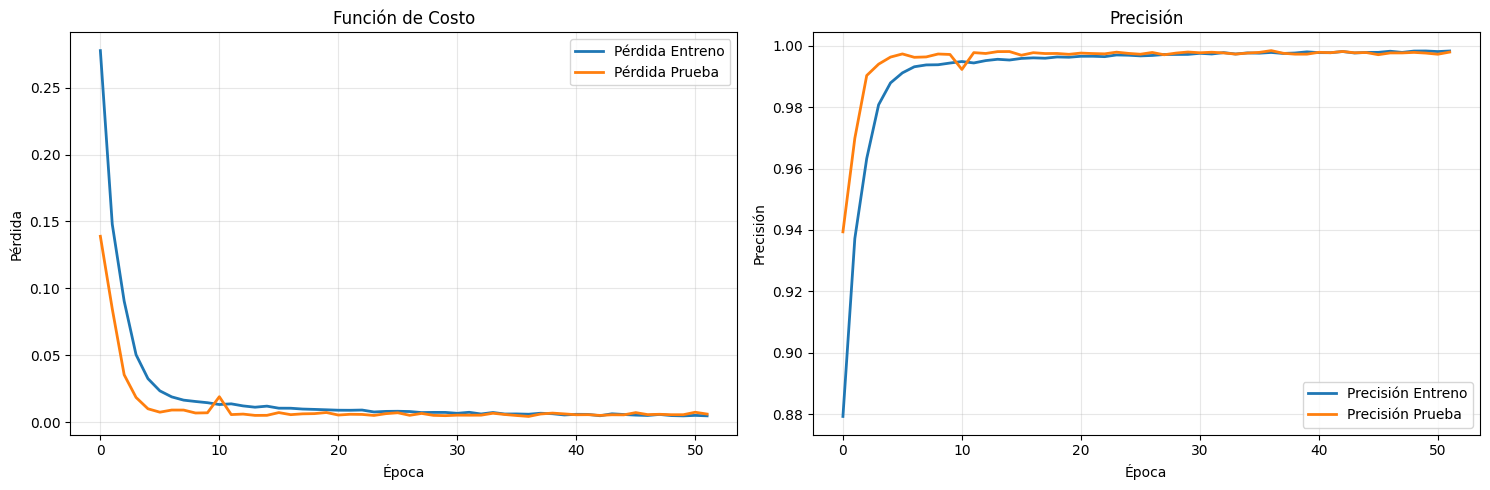

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(historial.history['loss'], label='Pérdida Entreno', linewidth=2)
ax1.plot(historial.history['val_loss'], label='Pérdida Prueba', linewidth=2)
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Función de Costo')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(historial.history['accuracy'], label='Precisión Entreno', linewidth=2)
ax2.plot(historial.history['val_accuracy'], label='Precisión Prueba', linewidth=2)
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.set_title('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_entrenamiento.png', dpi=300, bbox_inches='tight')
plt.show()

mlflow.log_artifact('curvas_entrenamiento.png')

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


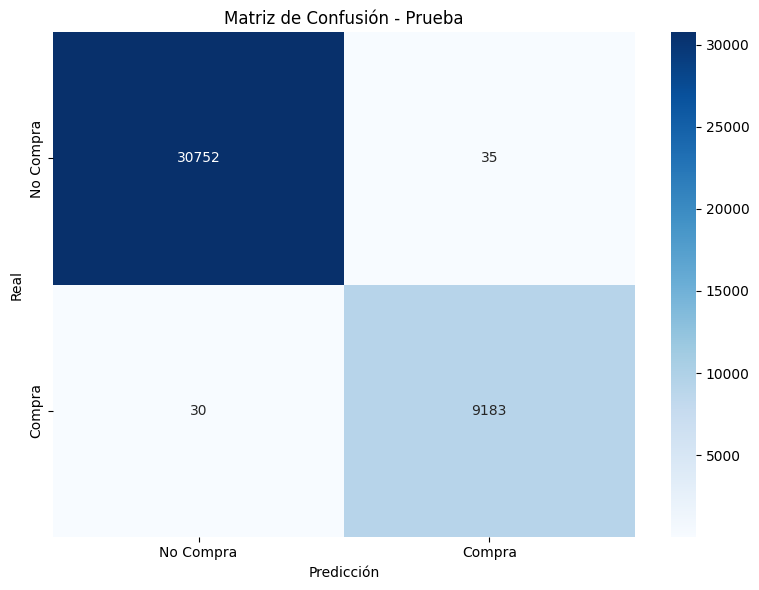


Reporte de Clasificación (Prueba):
              precision    recall  f1-score   support

   No Compra       1.00      1.00      1.00     30787
      Compra       1.00      1.00      1.00      9213

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



In [18]:
y_pred_prueba = (modelo_final.predict(X_prueba) > 0.5).astype(int).flatten()
mc = confusion_matrix(y_prueba, y_pred_prueba)

plt.figure(figsize=(8, 6))
sns.heatmap(mc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Compra', 'Compra'],
            yticklabels=['No Compra', 'Compra'])
plt.title('Matriz de Confusión - Prueba')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig('matriz_confusion_prueba.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nReporte de Clasificación (Prueba):")
print(classification_report(y_prueba, y_pred_prueba, target_names=['No Compra', 'Compra']))

mlflow.log_artifact('matriz_confusion_prueba.png')